In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, make_scorer
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_validate
import time
import seaborn as sns

Using TensorFlow backend.


In [2]:
house_data = pd.read_csv("../preprocessed_data/oneHot_data.csv")

In [3]:
house_data.head()

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,Day,HourofDay,...,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,Thermostat_Motion,Remote_Sensor_1_Temperature,Remote_Sensor_1_Motion,T_out,RH_out
0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,11,0.330465,0.0,67.0,0.0,0.009112,1.808865
1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,2,9,0.330465,0.0,67.0,0.0,0.009112,1.808865
2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,20,20,0.330465,0.0,67.0,0.0,0.009112,1.808865
3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,9,12,0.330465,0.0,67.0,0.0,0.009112,1.808865
4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,1,0,...,0.663321,0.177458,0,8,0.330465,0.0,67.0,0.0,0.009112,1.808865


In [4]:
house_data.columns

Index(['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'Month', 'DayOfWeek', 'Day', 'HourofDay', 'HvacMode_heat', 'Event_Hold',
       'Event_None', 'Schedule_Away', 'Schedule_Home', 'Schedule_Sleep',
       'T_ctrl', 'T_stp_heat', 'Humidity', 'auxHeat1', 'fan',
       'Thermostat_Temperature', 'Thermostat_Motion',
       'Remote_Sensor_1_Temperature', 'Remote_Sensor_1_Motion', 'T_out',
       'RH_out'],
      dtype='object')

In [5]:
working_df = house_data[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

In [6]:
working_df.head()

,T_ctrl,T_stp_heat,T_out,RH_out,auxHeat1
0,0.311691,0.663321,0.009112,1.808865,0
1,0.311691,0.663321,0.009112,1.808865,2
2,0.311691,0.663321,0.009112,1.808865,20
3,0.311691,0.663321,0.009112,1.808865,9
4,0.311691,0.663321,0.009112,1.808865,0


In [7]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Model House

In [8]:
reframed = series_to_supervised(working_df, 6, 1)

In [9]:
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
6,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,2.0,...,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.075007,1.877919,0
7,0.311691,0.663321,0.009112,1.808865,2.0,0.311691,0.663321,0.009112,1.808865,20.0,...,0.311691,0.663321,0.075007,1.877919,0.0,0.311691,0.663321,0.075007,1.877919,0
8,0.311691,0.663321,0.009112,1.808865,20.0,0.311691,0.663321,0.009112,1.808865,9.0,...,0.311691,0.663321,0.075007,1.877919,0.0,0.311691,0.663321,0.075007,1.877919,14
9,0.311691,0.663321,0.009112,1.808865,9.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.877919,14.0,0.311691,0.663321,0.075007,1.877919,19
10,0.311691,0.663321,0.009112,1.808865,0.0,0.311691,0.663321,0.009112,1.808865,0.0,...,0.311691,0.663321,0.075007,1.877919,19.0,0.311691,0.663321,0.075007,1.877919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58832,0.311691,0.663321,-0.649837,-0.055597,10.0,0.311691,0.663321,-0.649837,-0.055597,20.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0
58833,0.311691,0.663321,-0.649837,-0.055597,20.0,0.311691,0.663321,-0.649837,-0.055597,20.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0
58834,0.311691,0.663321,-0.649837,-0.055597,20.0,0.311691,0.663321,-0.649837,-0.055597,9.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0
58835,0.311691,0.663321,-0.649837,-0.055597,9.0,0.311691,0.663321,-0.649837,-0.055597,0.0,...,0.311691,0.663321,-0.649837,-0.124651,0.0,0.311691,0.663321,-0.649837,-0.124651,0


In [10]:
y_auxHeat = reframed['var5(t)']
#y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

In [11]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

In [12]:
# X_train = X_train.values
# X_test = X_test.values

In [13]:
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

### ReLu

In [14]:
def build_classifier_relu():

    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

    # Adding the second hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

    # Adding the output layer
    classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [15]:
classifier = KerasClassifier(build_fn = build_classifier_relu, batch_size = 64, nb_epoch = 50)

In [16]:
scoring = {'acc': 'accuracy',
           'f1_weighted': 'f1_weighted'}

In [17]:
ac_funcs = ['relu', 'logistic', 'tanh']
ac_funcs_score_time = []
ac_funcs_acc = []
ac_funcs_f1 = []

In [18]:
start = time.time()
scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, scoring = scoring, cv = 10)
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_acc'])
ac_funcs_f1.append(scores['test_f1_weighted'])

828/828 [==============================] - 2s 3ms/step - loss: 0.9401 - accuracy: 0.8220


### Sigmoid

In [19]:
def build_classifier_sigmoid():

    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'sigmoid', input_dim = 34))

    # Adding the second hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'sigmoid'))

    # Adding the output layer
    classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [20]:
classifier = KerasClassifier(build_fn = build_classifier_sigmoid, batch_size = 64, nb_epoch = 50)

scoring = {'acc': 'accuracy',
           'f1_weighted': 'f1_weighted'}

start = time.time()
scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, scoring = scoring, cv = 10)
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_acc'])
ac_funcs_f1.append(scores['test_f1_weighted'])

828/828 [==============================] - 2s 3ms/step - loss: 1.1083 - accuracy: 0.7199


### Tanh

In [21]:
def build_classifier_tanh():

    classifier = Sequential()

    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'tanh', input_dim = 34))

    # Adding the second hidden layer
    classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'tanh'))

    # Adding the output layer
    classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [22]:
classifier = KerasClassifier(build_fn = build_classifier_tanh, batch_size = 64, nb_epoch = 50)

scoring = {'acc': 'accuracy',
           'f1_weighted': 'f1_weighted'}

start = time.time()
scores = cross_validate(estimator = classifier, X = X, y = y_auxHeat, scoring = scoring, cv = 10)
ac_funcs_score_time.append(scores['score_time'])
ac_funcs_acc.append(scores['test_acc'])
ac_funcs_f1.append(scores['test_f1_weighted'])

828/828 [==============================] - 3s 3ms/step - loss: 1.0101 - accuracy: 0.8017


In [23]:
ac_funcs_acc

[array([0.79265806, 0.7654258 , 0.77069522, 0.86945436, 0.91789903,
        0.96855346, 0.97875234, 0.83970763, 0.80894102, 0.81336053]),
 array([0.48283481, 0.44688084, 0.58473568, 0.78106408, 0.85398606,
        0.95614482, 0.96583376, 0.78446371, 0.66836648, 0.64133945]),
 array([0.78925901, 0.77460479, 0.78174401, 0.87540371, 0.92265851,
        0.97008329, 0.97977223, 0.84412715, 0.81370049, 0.82168961])]

In [48]:
acc_df = pd.DataFrame(ac_funcs_acc)
acc_df = acc_df.T

In [53]:
acc_df = acc_df.rename(columns = {0:'ReLu', 1:'Sigmoid', 2:'Tanh'})

In [54]:
acc_df

,ReLu,Sigmoid,Tanh
0,0.792658,0.482835,0.789259
1,0.765426,0.446881,0.774605
2,0.770695,0.584736,0.781744
3,0.869454,0.781064,0.875404
4,0.917899,0.853986,0.922659
5,0.968553,0.956145,0.970083
6,0.978752,0.965834,0.979772
7,0.839708,0.784464,0.844127
8,0.808941,0.668366,0.813700
9,0.813361,0.641339,0.821690


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Activation Function Used')]

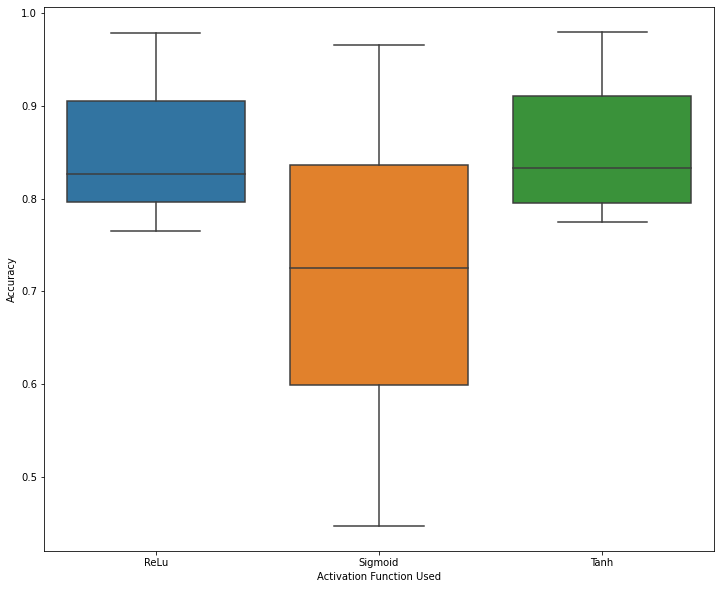

In [57]:
plt.figure(figsize = (12, 10))
ax = sns.boxplot(data = acc_df)
ax.set(ylabel = "Accuracy", xlabel = "Activation Function Used")

[Text(0, 0.5, 'Weighted F1-Score'), Text(0.5, 0, 'Activation Function Used')]

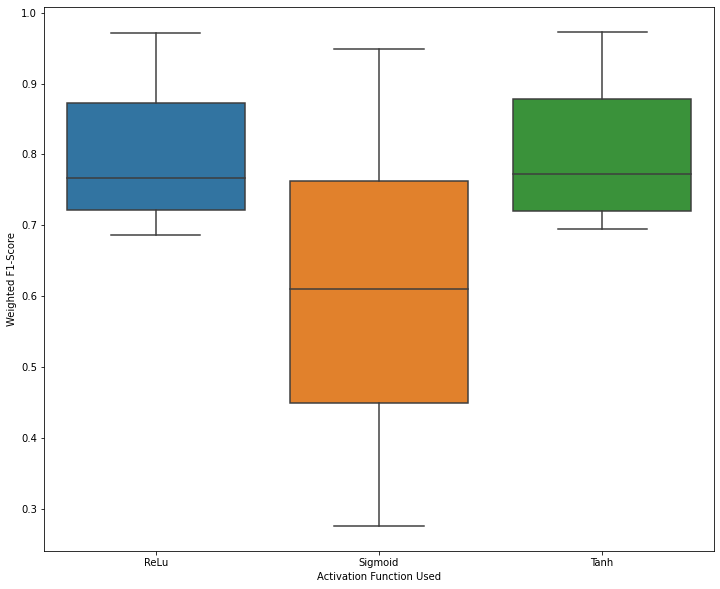

In [58]:
f1_df = pd.DataFrame(ac_funcs_f1)
f1_df = f1_df.T

f1_df = f1_df.rename(columns = {0:'ReLu', 1:'Sigmoid', 2:'Tanh'})

plt.figure(figsize = (12, 10))
ax = sns.boxplot(data = f1_df)
ax.set(ylabel = "Weighted F1-Score", xlabel = "Activation Function Used")

[Text(0, 0.5, 'Time Taken for Prediction'),
 Text(0.5, 0, 'Activation Function Used')]

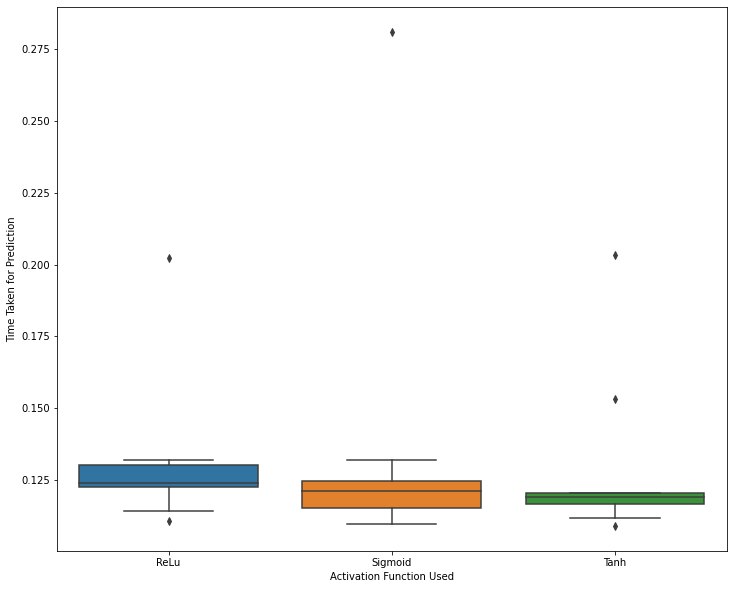

In [60]:
time_df = pd.DataFrame(ac_funcs_score_time)
time_df = time_df.T

time_df = time_df.rename(columns = {0:'ReLu', 1:'Sigmoid', 2:'Tanh'})

plt.figure(figsize = (12, 10))
ax = sns.boxplot(data = time_df)
ax.set(ylabel = "Time Taken for Prediction", xlabel = "Activation Function Used")